## Estimation of the payoff of the European Call Option using Quantum circuits

In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit_finance.circuit.library import LogNormalDistribution
import numpy as np
from qiskit.quantum_info import Statevector

In [2]:
# Implementing the log-normal-distribution


# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 300 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
# sigma = vol * np.sqrt(T)
sigma=0.1 # sigma=10%
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

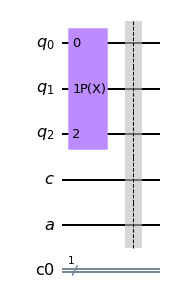

In [3]:
uncertainty_model.draw('mpl')

# Defining some constants
num_of_qubits=3

q=QuantumRegister(num_of_qubits,name="q")
q_c=QuantumRegister(1,name="c")
q_a=QuantumRegister(1,name="a")
c=ClassicalRegister(1)
qc=QuantumCircuit(q,q_c,q_a,c)
qc.append(uncertainty_model,range(num_uncertainty_qubits))
qc.barrier()

qc.draw("mpl")

In [4]:
psi=Statevector(qc)
psi.draw("latex")

<IPython.core.display.Latex object>

In [5]:
# To see the log normal distribution

# qc.measure(q,c)
# qc.draw('mpl')

# from qiskit import transpile
# from qiskit.providers.aer import QasmSimulator
# backend=QasmSimulator()
# qc_compiled=transpile(qc,backend)
# job = backend.run(qc_compiled,shot=1024)
# result=job.result()
# counts=result.get_counts()
# print(counts)
# from qiskit.visualization import plot_histogram
# plot_histogram(counts)

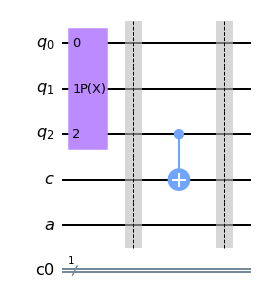

In [7]:
k=2 # Strike price

# Implementing the comparitor circuit for the given strike price

qc.cx(q[2],q_c[0])
qc.barrier()
qc.draw("mpl")


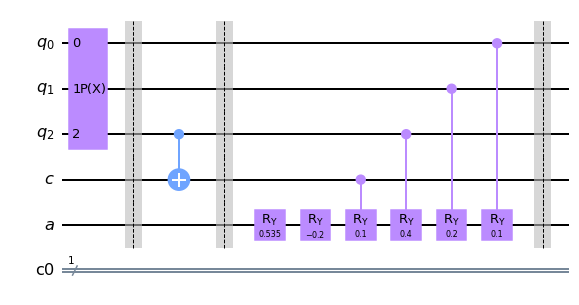

In [8]:
from math import pi

# constants
C=0.25  # scalling factor
i_max=(2**num_of_qubits)-1  #2^n-1

# f(i)=f0+f1*i
f0=-(2*C*k)/(i_max-k) 
f1=(2*C)/(i_max-k)

g0=(pi/4)-C

# circuit
qc.ry(g0,q_a[0])

# making the Ry[g(i)] part
qc.ry(f0,q_a[0])
qc.cry(f1,q_c[0],q_a[0])
qc.cry(4*f1,q[2],q_a[0])
qc.cry(2*f1,q[1],q_a[0])
qc.cry(f1,q[0],q_a[0])

qc.barrier()

qc.draw('mpl')

In [9]:
psi=Statevector(qc)
psi.draw('latex')

<IPython.core.display.Latex object>

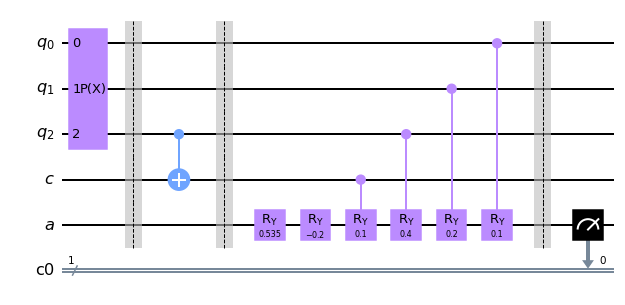

In [10]:
qc.measure(q_a,c)
qc.draw('mpl')

{'0': 2}


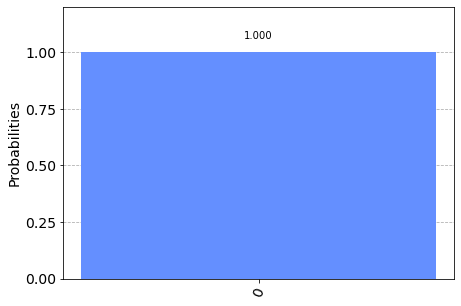

In [11]:
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
backend=QasmSimulator()
qc_compiled=transpile(qc,backend)
job = backend.run(qc_compiled,shots=2)
result=job.result()
counts=result.get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts,sort="value")

In [18]:
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator

m=[3,5,7,9,11,13]  #different no.of shots
a_l=[]  # stores the expected payoff for different no.of shots

for i in m:
    M=2**i
    backend=QasmSimulator()
    qc_compiled=transpile(qc,backend)
    job = backend.run(qc_compiled,shots=M)
    result=job.result()
    counts=result.get_counts()
    print(counts)
    a_l+=[counts["1"]/(2**i)]

for i in range(len(a_l)):
    print("expected payoff for m =",m[i]," is =",a_l[i])
    
    

{'0': 6, '1': 2}
{'0': 26, '1': 6}
{'1': 22, '0': 106}
{'0': 436, '1': 76}
{'0': 1799, '1': 249}
{'0': 7097, '1': 1095}
expected payoff for m = 3  is = 0.25
expected payoff for m = 5  is = 0.1875
expected payoff for m = 7  is = 0.171875
expected payoff for m = 9  is = 0.1484375
expected payoff for m = 11  is = 0.12158203125
expected payoff for m = 13  is = 0.1336669921875


## Estimation of the payoff of the European call option using  Black-Scholes-Merton model(Classical method)

In [19]:
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf

In [20]:
def euro_vanilla_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [21]:
print(euro_vanilla_call(S, k, T, r, sigma))

0.11826974870793228
